### Libraries 

In [271]:
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt
import spacy as sp
import pandas as pd
import seaborn as sns
import json
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams  
from nltk.stem import PorterStemmer
from pandas.io.json import json_normalize 
import legibilidad
#Source: https://github.com/amunozf/legibilidad
from lexical_diversity import lex_div as ld
#Source: https://pypi.org/project/lexical-diversity/
stop = stopwords.words('spanish')

nlp = sp.load("es")


### User-defined functions


In [254]:
def lexical_diversity(text):
    """
    Function takes in string object and compute lexical diversity.
    It returns a string.
    ------------
    Paramenters:
    text: string. document to be analyzed.
    ------------
    Returns:
    string
    """
    return len(set(text)) / len(text)

def sanitize_text(df, col):
    """
    Function takes a dataframe and column name and cleans said column. 
    ------------
    Paramenters:
    df: pandas dataFrame. dataframe
    col: string, column name
    ------------
    Returns:
    pandas dataFrame
    """
    df[col+' Cleaned'] = df[col].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[col+' Cleaned'] = df[col+' Cleaned'].replace('[^\w\s]', '')
    df[col+' Cleaned'] = df[col+' Cleaned'].str.lower()
    return df

def avg_word(sentence):
    """
    Function takes in a string and computes the average number of words.
    ------------
    Paramenters:
    sentence: string. 
    ------------
    Returns:
    int
    """
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

def rank_words(terms, feature_matrix):
    """
    Display top comments by topic.
    """
    sums = feature_matrix.sum(axis=0)
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col]) )
    ranked = pd.DataFrame(data, columns=['term','rank']).sort_values('rank', ascending=False)
    return ranked

def rank_words(terms, feature_matrix):
    """
    Display top comments by topic.
    """
    sums = feature_matrix.sum(axis=0)
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col]) )
    ranked = pd.DataFrame(data, columns=['term','rank']).sort_values('rank', ascending=False)
    return ranked

def word_prob(word): 
    """
    Computes the probability of each word in the dictionary. 
    """
    return dictionary[word] / total

def words(text): 
    """
    Transforms words into proper format.
    """
    return re.findall('[a-z]+', text.lower()) 

def viterbi_segment(text):
    """
    Use viterbi's algorithm to find the maximum probabilities of words in a 
    merged string. NOTE: Must be fed lowercase strings.
    
    """
    #Initialize state memory
    probs, lasts = [1.0], [0] 
    #Loop over number of observations
    for i in range(1, len(text) + 1):
        #Loop over possible new states, loop over old states, compute new path
        prob_k, k = max((probs[j] * word_prob(text[j:i]), j)
                        for j in range(max(0, i - max_word_length), i))
     
        probs.append(prob_k)
        lasts.append(k)
    words = []
    i = len(text)
    #Search for most prob. transition
    while 0 < i:
        words.append(text[lasts[i]:i])
        i = lasts[i]
    words.reverse()
    return words, probs[-1]


def sanitize(text):
    """
    Removes any leftover HTML tags.
    Takes in a single string.
    
    """
    newText = text.replace("&nbsp", "")
    newText = newText.replace("&", "")
    newText = newText.replace("\xa0", "")
    newText = newText.replace("\t", "")
    return newText

def avg_word(sentence):
    """
    Get average word length.
    """
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

def ngram_filter(tokens, n):
    all_ngrams = ngrams(tokens, n)
    filtered_ngrams = [x for x in all_ngrams]
    newgrams = [' '.join(x) for x in filtered_ngrams]
    return newgrams

def ngram_generator(comment_list, ngram_count):
    text_ngram = []
    for comment in comment_list:
        temp = ngram_filter(comment, ngram_count)
        text_ngram.extend(temp)
        
    ngram_dat = pd.DataFrame(text_ngram)
    ngram_counts = pd.DataFrame(ngram_dat.groupby(0).size())
    ngram_counts.index.names = ['ngram']
    ngram_counts.columns = ['count']
    ngram_counts.sort_values(by = 'count', ascending = False, inplace=True)
    ngram_counts.reset_index(level=0, inplace=True)
    ngram_counts = ngram_counts.head(100)
    
    return ngram_counts


### Data Preparation

In [375]:
#--- Read data
filename = 'merengue.json'
with open(filename) as data_file:    
    data = json.load(data_file)  
df = json_normalize(data, 'data', ['artist','song', 'lyrics'], 
                    record_prefix='data_',errors='ignore')
df.drop(["song", "artist", "lyrics", "data_url"], axis=1, inplace=True)

In [376]:
df.head()

,data_artist,data_song,data_lyrics
0,,la-combinacion-vallenata,Corazón yo sería como el viento libre libreAy ...
1,,juan-luis-guerra,Tengo un Dios admirable en los cielosy el amor...
2,,juan-luis-guerra,Tengo un corazónMutilado de esperanza y de raz...
3,,juan-luis-guerra,Yo era de un barrio pobreDel centro de la ciud...
4,,juan-luis-guerra,"Oye, me dio una fiebre el otro díaPor causa de..."


In [377]:
len(df.data_lyrics)

498

In [378]:
df = df[(df.data_song != 'macaco') & (df.data_song != 'las-pelotas')]
df.reset_index(inplace=True, drop=True)

In [379]:
#Convert to spacy, object, remove puntuation and tokenize.
placeholder = []
for song in range(len(df.data_lyrics)):
    doc = nlp(df.data_lyrics[song])
    placeholder.append([token.orth_ for token in doc 
                                  if not token.is_punct | token.is_space])
df['tokenized_song'] = placeholder

In [380]:
df['tokenized_song'].head()

0    [Corazón, yo, sería, como, el, viento, libre, ...
1    [Tengo, un, Dios, admirable, en, los, cielosy,...
2    [Tengo, un, corazónMutilado, de, esperanza, y,...
3    [Yo, era, de, un, barrio, pobreDel, centro, de...
4    [Oye, me, dio, una, fiebre, el, otro, díaPor, ...
Name: tokenized_song, dtype: object

### Grammatical Properties

In [381]:
df['silabas_por_palabra'] = df['data_lyrics'].apply(legibilidad.Pval)
df['palabras_por_oracion'] = df['data_lyrics'].apply(legibilidad.Fval)
df['numero_palabras_por_cancion']= df['data_lyrics'].apply(legibilidad.count_words)

In [382]:
df[['silabas_por_palabra','palabras_por_oracion', 'numero_palabras_por_cancion']].describe()

,silabas_por_palabra,palabras_por_oracion,numero_palabras_por_cancion
count,498.000000,498.000000,498.000000
mean,1.936888,83.558795,213.755020
std,0.219580,82.984125,95.219519
min,1.430000,2.210000,27.000000
25%,1.790000,19.125000,148.000000
50%,1.910000,48.835000,206.000000
75%,2.047500,134.000000,265.750000
max,3.310000,384.000000,639.000000


### Lexical Diversity

In [383]:
df['lexical_diversity'] = df['tokenized_song'].apply(lexical_diversity)

In [384]:
df['lexical_diversity'].describe()

count    498.000000
mean       0.456674
std        0.136926
min        0.143695
25%        0.358466
50%        0.440549
75%        0.537468
max        0.962963
Name: lexical_diversity, dtype: float64

In [385]:
#Max and Min
max_= df['lexical_diversity'].idxmax()
min_ = df['lexical_diversity'].idxmin()

In [386]:
print(df.data_song[max_]+"\n")
print(df.data_song[min_])

juan-luis-guerra

juan-luis-guerra


In [387]:
averages_ld_per_singer = df.groupby('data_song')['lexical_diversity'].mean()

In [388]:
averages_ld_per_singer.sort_values().tail(45)

data_song
chimbala                    0.319459
jandy-feliz                 0.408058
hector-acosta               0.432914
wilfrido-vargas             0.437280
eddy-herrera                0.449162
juan-luis-guerra            0.459719
milly-quezada               0.466434
la-combinacion-vallenata    0.468564
too-rosario                 0.472921
sergio-vargas               0.475340
Name: lexical_diversity, dtype: float64

In [389]:
averages_ld_per_singer.to_csv("test.csv")

/Users/vn50lkl/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [390]:
averages_ld_per_singer.sort_values().head()

data_song
chimbala           0.319459
jandy-feliz        0.408058
hector-acosta      0.432914
wilfrido-vargas    0.437280
eddy-herrera       0.449162
Name: lexical_diversity, dtype: float64

### Readability

In [391]:
df['fernandez_huerta'] = df['data_lyrics'].apply(legibilidad.fernandez_huerta)
df['fernandez_huerta_int'] = df['fernandez_huerta'].apply(legibilidad.interpretaL)

df['gutierrez'] = df['data_lyrics'].apply(legibilidad.gutierrez)
df['gutierrez_int'] = df['gutierrez'].apply(legibilidad.gutierrez_interpret)

df['szigriszt_pazos'] = df['data_lyrics'].apply(legibilidad.szigriszt_pazos)
df['szigriszt_pazos_int'] = df['szigriszt_pazos'].apply(legibilidad.interpretaP)

In [392]:
df.head()

,data_artist,data_song,data_lyrics,tokenized_song,silabas_por_palabra,palabras_por_oracion,numero_palabras_por_cancion,lexical_diversity,fernandez_huerta,fernandez_huerta_int,gutierrez,gutierrez_int,szigriszt_pazos,szigriszt_pazos_int
0,,la-combinacion-vallenata,Corazón yo sería como el viento libre libreAy ...,"[Corazón, yo, sería, como, el, viento, libre, ...",1.82,276.00,276,0.474638,-183.88,muy difícil,-44.38,difícil,-182.70,muy difícil
1,,juan-luis-guerra,Tengo un Dios admirable en los cielosy el amor...,"[Tengo, un, Dios, admirable, en, los, cielosy,...",1.55,6.40,461,0.343182,107.31,muy fácil,56.73,normal,104.08,muy fácil
2,,juan-luis-guerra,Tengo un corazónMutilado de esperanza y de raz...,"[Tengo, un, corazónMutilado, de, esperanza, y,...",2.07,16.40,246,0.365957,65.91,normal,43.48,normal,61.78,normal
3,,juan-luis-guerra,Yo era de un barrio pobreDel centro de la ciud...,"[Yo, era, de, un, barrio, pobreDel, centro, de...",2.04,53.20,266,0.449057,30.18,difícil,33.44,normal,26.46,árido
4,,juan-luis-guerra,"Oye, me dio una fiebre el otro díaPor causa de...","[Oye, me, dio, una, fiebre, el, otro, díaPor, ...",1.98,9.06,163,0.605096,78.80,bastante fácil,50.55,normal,74.33,bastante fácil


In [393]:
print(df.fernandez_huerta_int.value_counts())
print("\n")
print(df.gutierrez_int.value_counts())
print("\n")
print(df.szigriszt_pazos_int.value_counts())

muy difícil         228
bastante fácil       56
difícil              55
fácil                48
normal               42
muy fácil            37
bastante difícil     32
Name: fernandez_huerta_int, dtype: int64


difícil    249
normal     249
Name: gutierrez_int, dtype: int64


muy difícil         211
bastante fácil       58
normal               54
fácil                51
árido                50
muy fácil            39
bastante difícil     35
Name: szigriszt_pazos_int, dtype: int64


In [394]:
average_readability_per_singer = df.groupby('data_song')['fernandez_huerta'].mean()
print(average_readability_per_singer.sort_values().tail())
print("\n")
print(average_readability_per_singer.sort_values().head())

data_song
eddy-herrera        27.530000
juan-luis-guerra    28.770560
jandy-feliz         31.241875
milly-quezada       38.097241
chimbala            98.580000
Name: fernandez_huerta, dtype: float64


data_song
la-combinacion-vallenata   -69.333333
too-rosario                -36.771333
hector-acosta              -15.074717
wilfrido-vargas            -12.172727
sergio-vargas               13.709091
Name: fernandez_huerta, dtype: float64


### Parts of Speech


In [ ]:
#Quick look with spacy

In [214]:
all_text = df['data_lyrics'].str.cat(sep=', ')

In [220]:
all_text_comp = all_text[0:1000000]

In [221]:
doc = nlp(all_text_comp)

words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]

nouns = [token.text for token in doc if token.is_stop != True and token.is_punct != True and token.pos_ == "NOUN"]

verbs = [token.text for token in doc if token.is_stop != True and token.is_punct != True and token.pos_ == "VERB"]


In [233]:
#five most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common(20)

#five most common noun tokens
noun_freq = Counter(nouns)
common_nouns = noun_freq.most_common(20)

#five most common verb tokens
verb_freq = Counter(verbs)
common_verbs = verb_freq.most_common(20)

In [234]:
common_words

[('a', 3456),
 ('y', 3058),
 ('pa', 1088),
 ('quiero', 621),
 ('Y', 579),
 ('amor', 453),
 ('noche', 395),
 ('oh', 390),
 ('vida', 374),
 ('na', 336),
 ('to', 321),
 ('yeh', 285),
 ('eh', 248),
 ('quieres', 226),
 ('gusta', 197),
 ('mundo', 195),
 ('baby', 191),
 ('vas', 180),
 ('siento', 178),
 ('o', 172)]

In [235]:
common_nouns

[('amor', 411),
 ('noche', 384),
 ('vida', 371),
 ('mundo', 183),
 ('corazón', 151),
 ('cama', 146),
 ('yeh', 132),
 ('cuerpo', 130),
 ('tucu', 124),
 ('calle', 122),
 ('mujer', 106),
 ('quieres', 99),
 ('baby', 99),
 ('ojos', 95),
 ('casa', 93),
 ('gente', 93),
 ('disco', 84),
 ('sol', 83),
 ('mano', 82),
 ('par', 79)]

In [236]:
common_verbs

[('quiero', 600),
 ('gusta', 196),
 ('siento', 160),
 ('tienes', 144),
 ('to', 132),
 ('vas', 129),
 ('ve', 105),
 ('doy', 102),
 ('estás', 92),
 ('importa', 92),
 ('quieres', 91),
 ('pone', 87),
 ('digo', 83),
 ('pasa', 80),
 ('siente', 71),
 ('vivir', 69),
 ('quiera', 65),
 ('quieren', 64),
 ('veo', 64),
 ('ven', 63)]

#### Deeper Dive

Look into most common and uncommon terms.

In [340]:
df = sanitize_text(df, "data_lyrics")

In [341]:
df['data_lyrics Cleaned'] = df['data_lyrics Cleaned'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


In [291]:
freq_com = pd.Series(' '.join(df['data_lyrics Cleaned']).split()).value_counts()[:20]
freq_com

s         850
n         722
t         710
amor      652
m         620
si        588
quiero    388
coraz     321
,         318
vida      278
ay        276
d         256
oh        247
pa'       230
solo      217
ser       212
ah        203
puedo     200
est       189
voy       178
dtype: int64

In [292]:
freq_uncom = pd.Series(' '.join(df['data_lyrics Cleaned']).split()).value_counts()[-20:]
freq_uncom

didarise                  1
yonunca                   1
buena!                    1
avalansas                 1
poli                      1
intente                   1
amartesi                  1
arabia                    1
sentimientosterminaste    1
algarabia(2               1
lamentos,                 1
cariciasde                1
amoc                      1
falladoy                  1
amorespint                1
yo)me                     1
(dime)tu                  1
ehfogarat                 1
muchachita!!torito!!      1
(sea                      1
dtype: int64

In [303]:
df['data_lyrics Cleaned'] = df['data_lyrics Cleaned'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_com ))
df['data_lyrics Cleaned'] = df['data_lyrics Cleaned'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_uncom))

Look into ngrams and ranked terms.

In [304]:
tokenized_summary = [x.split() for x in df['data_lyrics Cleaned'].tolist()]
#You may change the n-gram count here. Keep in mind the specificity vs. context ratio
n_gram = ngram_generator(tokenized_summary, 3) 
n_gram

,ngram,count
0,"sac delo, sac",84
1,"delo, sac delo,",80
2,"delo, sac delosac",20
3,"sac delosac delo,",19
4,"delosac delo, sac",19
...,...,...
95,"reglas, juego pongo",3
96,verdadque nadaque sociedadpero,3
97,comera perros quemaste,2
98,as mismo so,2


In [264]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(3,4))    
tfidf = vectorizer.fit_transform(df['data_lyrics Cleaned'])

In [265]:
#Top weighted terms
ranked = rank_words(terms=vectorizer.get_feature_names(), feature_matrix=tfidf)
ranked[0:20]

,term,rank
174139,na na na,2.394951
295399,yeh yeh yeh,2.197041
5545,ah ah ah,2.139678
22369,ay ay ay,1.765269
270415,tra tra tra,1.645690
89539,eh eh eh,1.559439
174157,na na na na,1.388987
243333,shaky shaky shaky,1.331924
5546,ah ah ah ah,1.299295
181580,no no no,1.283409


In [266]:
#Set up NMF
n_topics = 20
nmf = NMF(n_components=n_topics,random_state=0)

topics = nmf.fit_transform(tfidf)
top_n_words = 5
t_words, word_strengths = {}, {}
for t_id, t in enumerate(nmf.components_):
    t_words[t_id] = [vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
t_words

{0: ['bailas forma provocatenerte',
  'enamoras es bailas',
  'enamoras es bailas forma',
  'es bailas forma',
  'es bailas forma provocatenerte'],
 1: ['reggaeton dalesigue bailando',
  'pareac rcate pantal',
  'reggaeton dalesigue bailando mami',
  'dalesigue bailando mami pareac',
  'mami pareac rcate'],
 2: ['sica botet quieres',
  'pongas bi nicaquieres',
  'syko come mierda sica',
  'bi nicaquieres patilla maravillaque',
  'note escoteque syko come'],
 3: ['peseny piernas caminenlos ojos',
  'peseny piernas caminenlos',
  'pesesea hicimos viday aunque',
  'nico pesesea hicimos',
  'aunque pase uoheres'],
 4: ['cantamos bien borrachosque bailamos',
  'borrachosnos besamos bien borrachos',
  'bailamos bien borrachosnos',
  'bien borrachosque bailamos bien',
  'bien borrachosque bailamos'],
 5: ['olvidar puedo escaparya',
  'puedo escaparya igual',
  'olvidar olvidar puedo escaparya',
  'olvidar olvidar puedo',
  'olvidar puedo escaparya igual'],
 6: ['calle oye hora',
  'autos limp

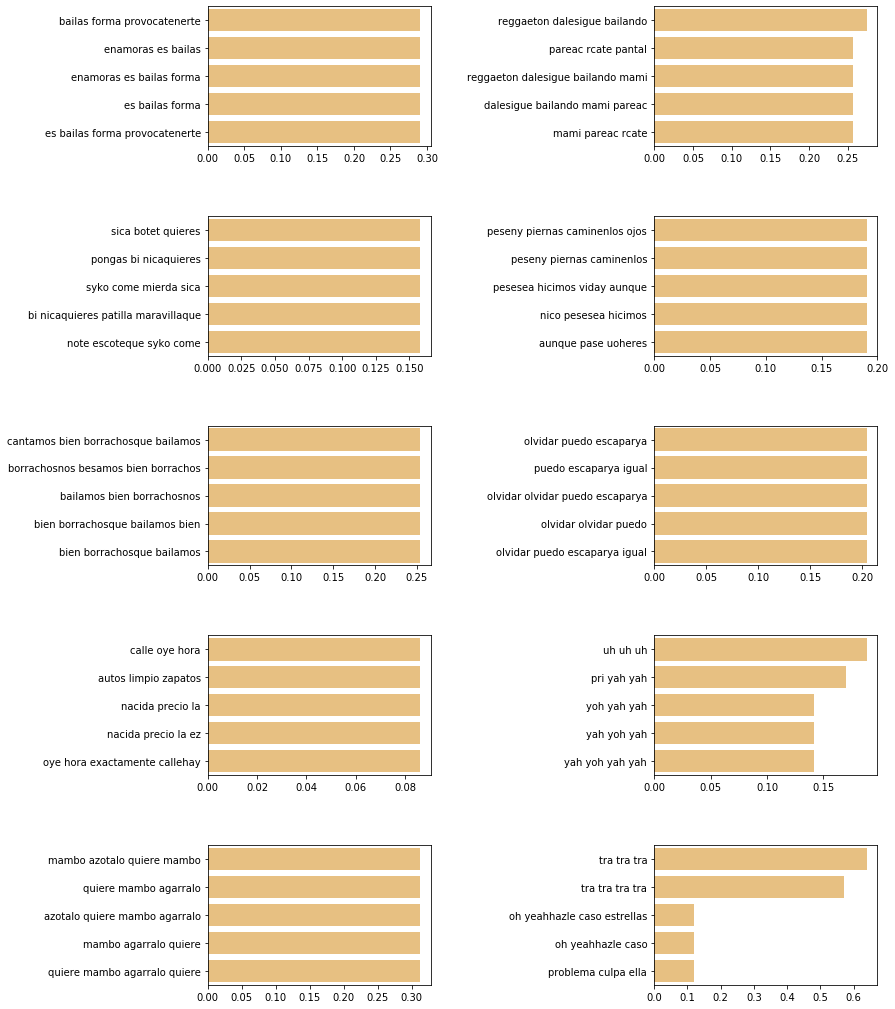

In [272]:
#---Visualize terms in NMF by rank
fig, ax = plt.subplots(figsize=(12,18), ncols=2, nrows=5)
plt.subplots_adjust(
    wspace  =  1.0,
    hspace  =  0.5
)
c=0
for row in range(0,5):
    for col in range(0,2):
        sns.barplot(x=word_strengths[c], y=t_words[c], color="#F8C471", ax=ax[row][col])
        c+=1
plt.show()